In [47]:
import sys
print(sys.version)
import os
import re
import glob
import datetime as dt

import numpy as np
np.set_printoptions(precision=5, linewidth=120, suppress=True)
import pandas as pd
pd.set_option('display.max_rows', None)
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [ ]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
alphaToken = None
 
if alphaToken is not None:
    import requests
    import time
    
    list_tickers = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
    
    for ticker in list_tickers:
        url = rf"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={alphaToken}&outputsize=full&datatype=csv"
        result = requests.get(url, allow_redirects=True)
        fname = f"daily_adjusted_{ticker}.csv"
        folder = "stock_data"
        if not os.path.isdir(folder):
            os.mkdir(folder)
        open(os.path.join(folder, fname), "wb").write(result.content)
        print(f"Downloaded {fname}.")
        # Limit is 5 downloads per minute.
        time.sleep(12)   

In [48]:
class DataReader:
    def __init__(self, folder_path, exclude=None):
        self.folder_path = folder_path
        self.name_format = r"daily_adjusted_*.csv"
        self.exclude = exclude if exclude is not None else []
        self.df_prices = None

    def read_data(self):
        # Get list of files from path, named as name_format 
        list_files = glob.glob(os.path.join(self.folder_path, self.name_format))
        file_names = "\n".join(list_files)
        print("Found data files: \n{}\n".format(file_names))

        # Exclude specified files
        for symbol in self.exclude:
            list_files.remove(os.path.join(self.folder_path, self.name_format.replace("*", symbol)))
    
        # Collect data from the files into a Dataframe
        dict_prices = {}
        for file_name in list_files: 
            m = re.search(self.name_format.replace("*", "(.+)"), file_name)
            
            # Get symbol name
            symbol = m.group(1)
        
            # Read data file
            df_data = pd.read_csv(file_name)

            # Set timestamp as index 
            df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])
            df_data = df_data.set_index('timestamp')
            df_data.index.name = "date"

            # Obtain adjusted close price data 
            dict_prices[symbol] = df_data['adjusted_close']

        self.df_prices = pd.concat(dict_prices.values(), axis=1, keys=dict_prices.keys()).sort_index()
        
    def get_period(self, start_date, end_date):              
        start_idx = self.df_prices.index.get_loc(pd.to_datetime(start_date), method='nearest')
        end_idx = self.df_prices.index.get_loc(pd.to_datetime(end_date), method='nearest')
        df_prices = self.df_prices.iloc[start_idx:(end_idx + 1)]
        
        return df_prices

In [49]:
# We load daily stock price data from CSV files. The data is adjusted for splits and dividends. 
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data")
dr.read_data()
df_prices = dr.get_period(start_date="2016-03-18", end_date="2021-03-18")
columns = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO", "SPY"]
df_prices = df_prices[columns]

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv



In [50]:
# Convert daily prices to weekly prices
df_weekly_prices = df_prices.resample('W').last()

In [51]:
# Compute weekly logarithmic returns
df_weekly_log_returns = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
df_weekly_log_returns = df_weekly_log_returns.dropna(how='all')
df_weekly_log_returns = df_weekly_log_returns.fillna(0)

array([[<AxesSubplot:title={'center':'PM'}>, <AxesSubplot:title={'center':'LMT'}>,
        <AxesSubplot:title={'center':'MCD'}>],
       [<AxesSubplot:title={'center':'MMM'}>, <AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'MSFT'}>],
       [<AxesSubplot:title={'center':'TXN'}>, <AxesSubplot:title={'center':'CSCO'}>,
        <AxesSubplot:title={'center':'SPY'}>]], dtype=object)

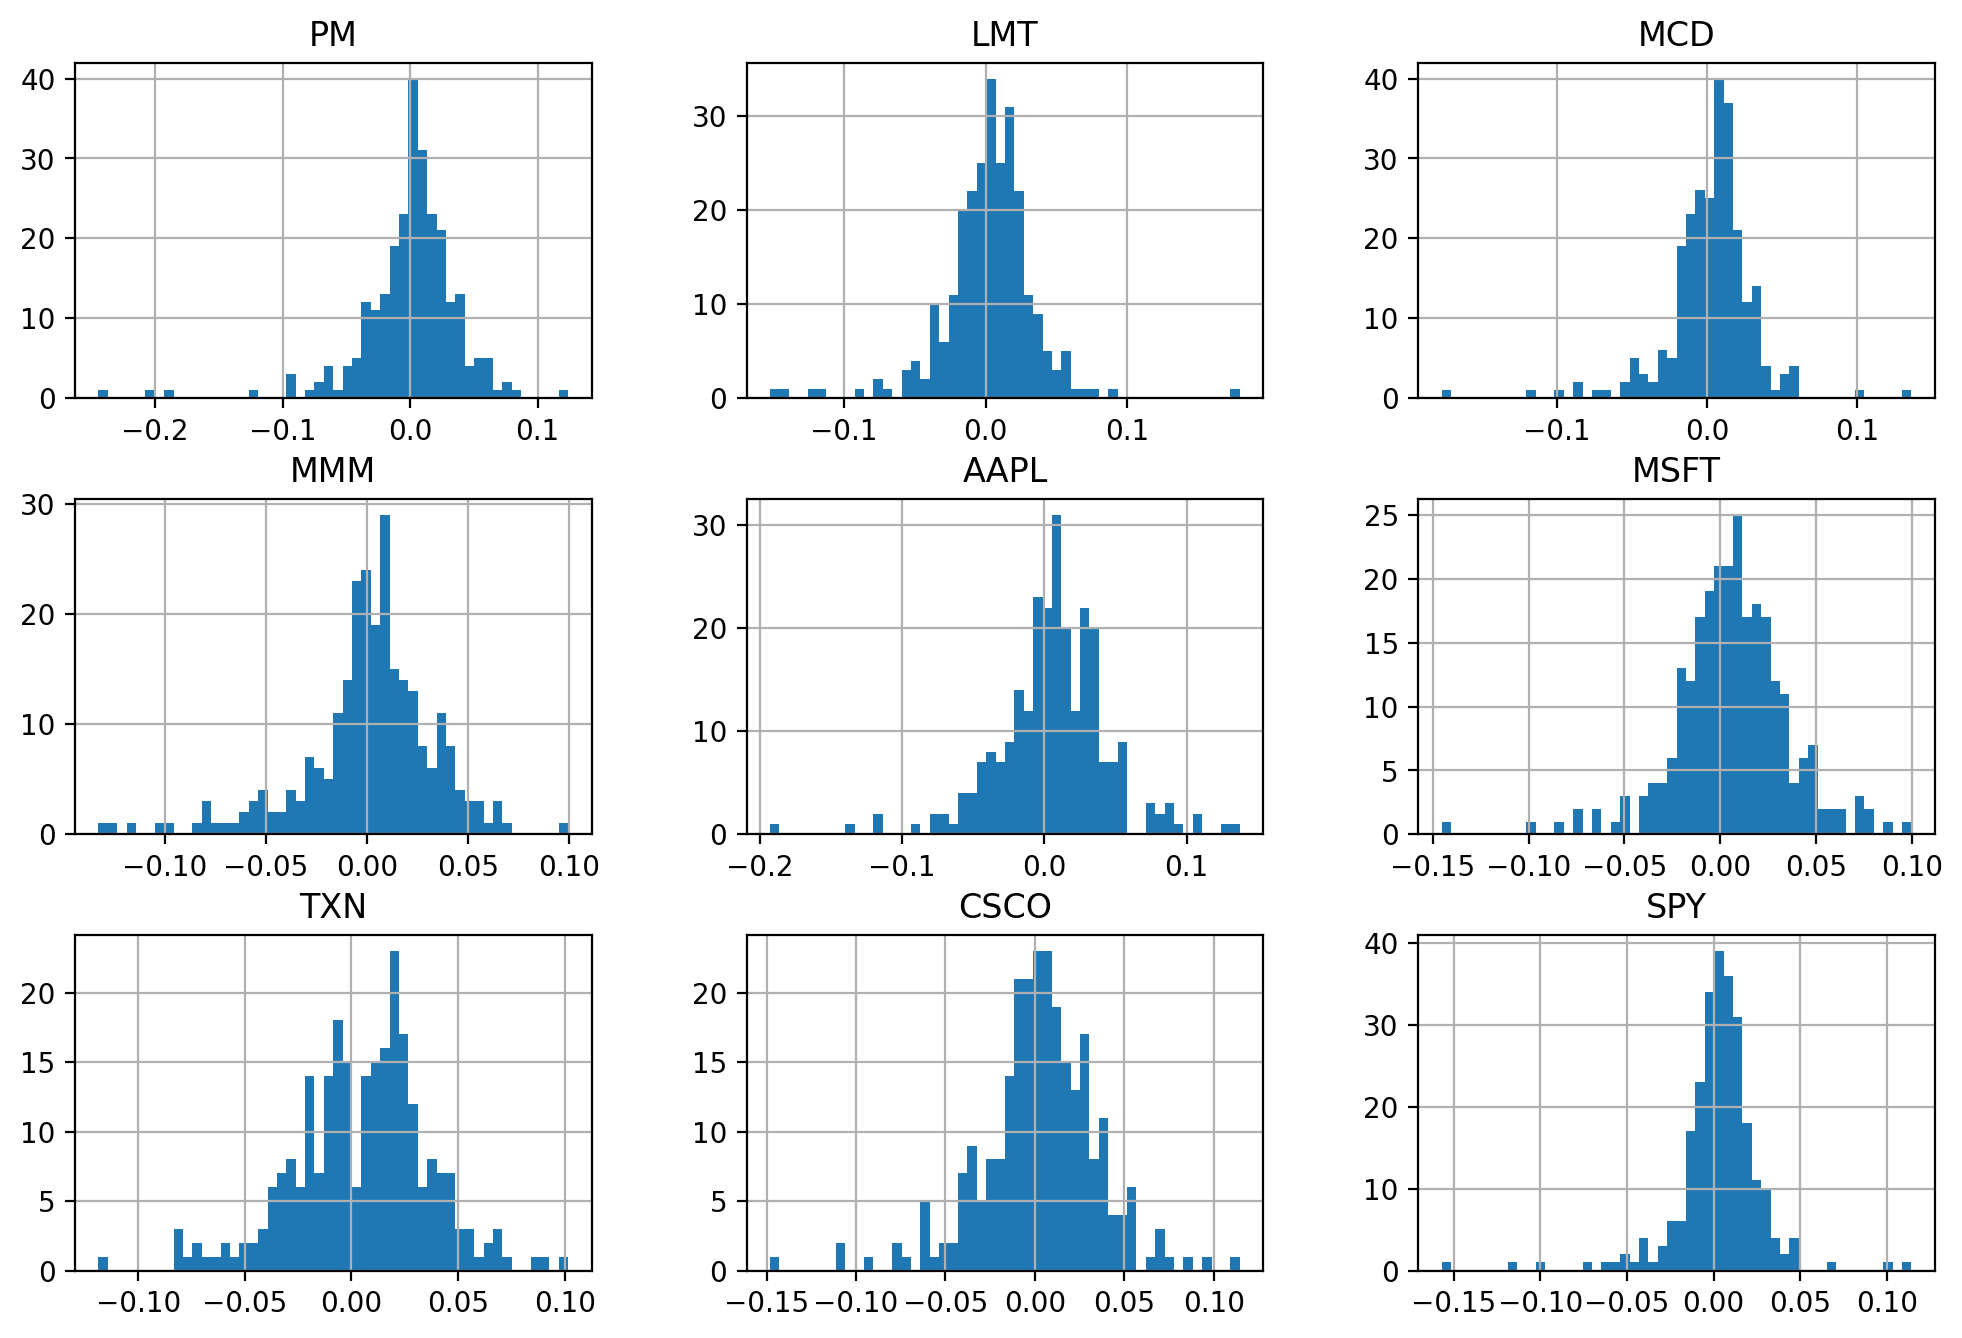

In [52]:
# Show histograms of weekly logarithmic returns
df_weekly_log_returns.hist(bins=50)

In [53]:
# Compute mean and covariance of weekly logarithmic returns
return_array = df_weekly_log_returns.to_numpy()
T = return_array.shape[0]
m_weekly_log = np.mean(return_array, axis=0)
S_weekly_log = np.cov(return_array.transpose())

In [54]:
# Convert weekly logarithmic return statistics to yearly linear return statistics
def get_lin_parameters(m_weekly_log, S_weekly_log):              
    # Project logarithmic return statistics to investment horizon
    m_log = 52 * m_weekly_log
    S_log = 52 * S_weekly_log
    
    # Pricing
    p_0 = df_weekly_prices.iloc[0].to_numpy()
    m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
    S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)
    
    # Linear return statistics on the investment horizon
    m = 1 / p_0 * m_P - 1
    S = 1 / np.outer(p_0, p_0) * S_P
    
    # Remove data corresponding to SPY
    m = m[:-1]
    S = S[:-1, :-1]

    return m, S

In [55]:
# Factor model
def factor_model(m_weekly_log, S_weekly_log):
    # Project logarithmic return statistics to investment horizon
    m_log = 52 * m_weekly_log
    S_log = 52 * S_weekly_log
    
    # Generate logarithmic return scenarios
    scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, 100000)
    
    # Convert logarithmic return scenarios to linear return scenarios 
    scenarios_lin = np.exp(scenarios_log) - 1
    
    # Do linear regression 
    params = []
    resid = []
    X = np.zeros((scenarios_lin.shape[0], 2))
    X[:, 0] = scenarios_lin[:, -1]
    X[:, 1] = 1
    for k in range(N):
        y = scenarios_lin[:, k]
        model = sm.OLS(y, X, hasconst=True).fit()
        resid.append(model.resid)
        params.append(model.params)
    resid = np.array(resid)
    params = np.array(params)
    
    # Get parameter estimates
    a = params[:, 1]
    B = params[:, 0]
    s_M = np.var(X[:, 0])
    S_theta = np.cov(resid)
    S_theta = np.diag(np.diag(S_theta))
    
    # Compute decomposition of S_theta
    G = np.block([[B[:, np.newaxis] * np.sqrt(s_M), np.sqrt(S_theta)]])
    print(G)
    
    return G

In [56]:
def EfficientFrontier(N, m, G, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
    
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, s)))

        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, Expr.mul(G.T, x)), Domain.inQCone())
    
        # Create DataFrame to store the results. Last security name (the SPY) is removed.
        columns = ["delta", "obj", "return", "risk"] + df_prices.columns[:-1].tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = s.level()[0]
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
            df_result = df_result.append(row, ignore_index=True)

        return df_result

In [61]:
# Number of securities (We subtract one to account for SPY)
N = df_prices.shape[1] - 1  

# Get optimization parameters
m_orig, S_orig = get_lin_parameters(m_weekly_log, S_weekly_log)

# Cholesky factor of S to use in conic risk constraint
G_orig = np.linalg.cholesky(S_orig)  
G_factor = factor_model(m_weekly_log, S_weekly_log)

[[0.17505 0.25444 0.      0.      0.      0.      0.      0.      0.     ]
 [0.18872 0.      0.20484 0.      0.      0.      0.      0.      0.     ]
 [0.17141 0.      0.      0.18079 0.      0.      0.      0.      0.     ]
 [0.17856 0.      0.      0.      0.18955 0.      0.      0.      0.     ]
 [0.27403 0.      0.      0.      0.      0.31312 0.      0.      0.     ]
 [0.22552 0.      0.      0.      0.      0.      0.2013  0.      0.     ]
 [0.22217 0.      0.      0.      0.      0.      0.      0.21821 0.     ]
 [0.18982 0.      0.      0.      0.      0.      0.      0.      0.21213]]


In [62]:
# Compute efficient frontier with and without factor model
deltas = np.logspace(start=-1, stop=1.5, num=20)[::-1]
df_result_orig = EfficientFrontier(N, m_orig, G_orig, deltas)
df_result_factor = EfficientFrontier(N, m_orig, G_factor, deltas)

# Set small negatives to zero to make plotting work
mask = df_result_orig < 0
mask.iloc[:, :-8] = False
df_result_orig[mask] = 0

# Set small negatives to zero to make plotting work
mask = df_result_factor < 0
mask.iloc[:, :-8] = False
df_result_factor[mask] = 0

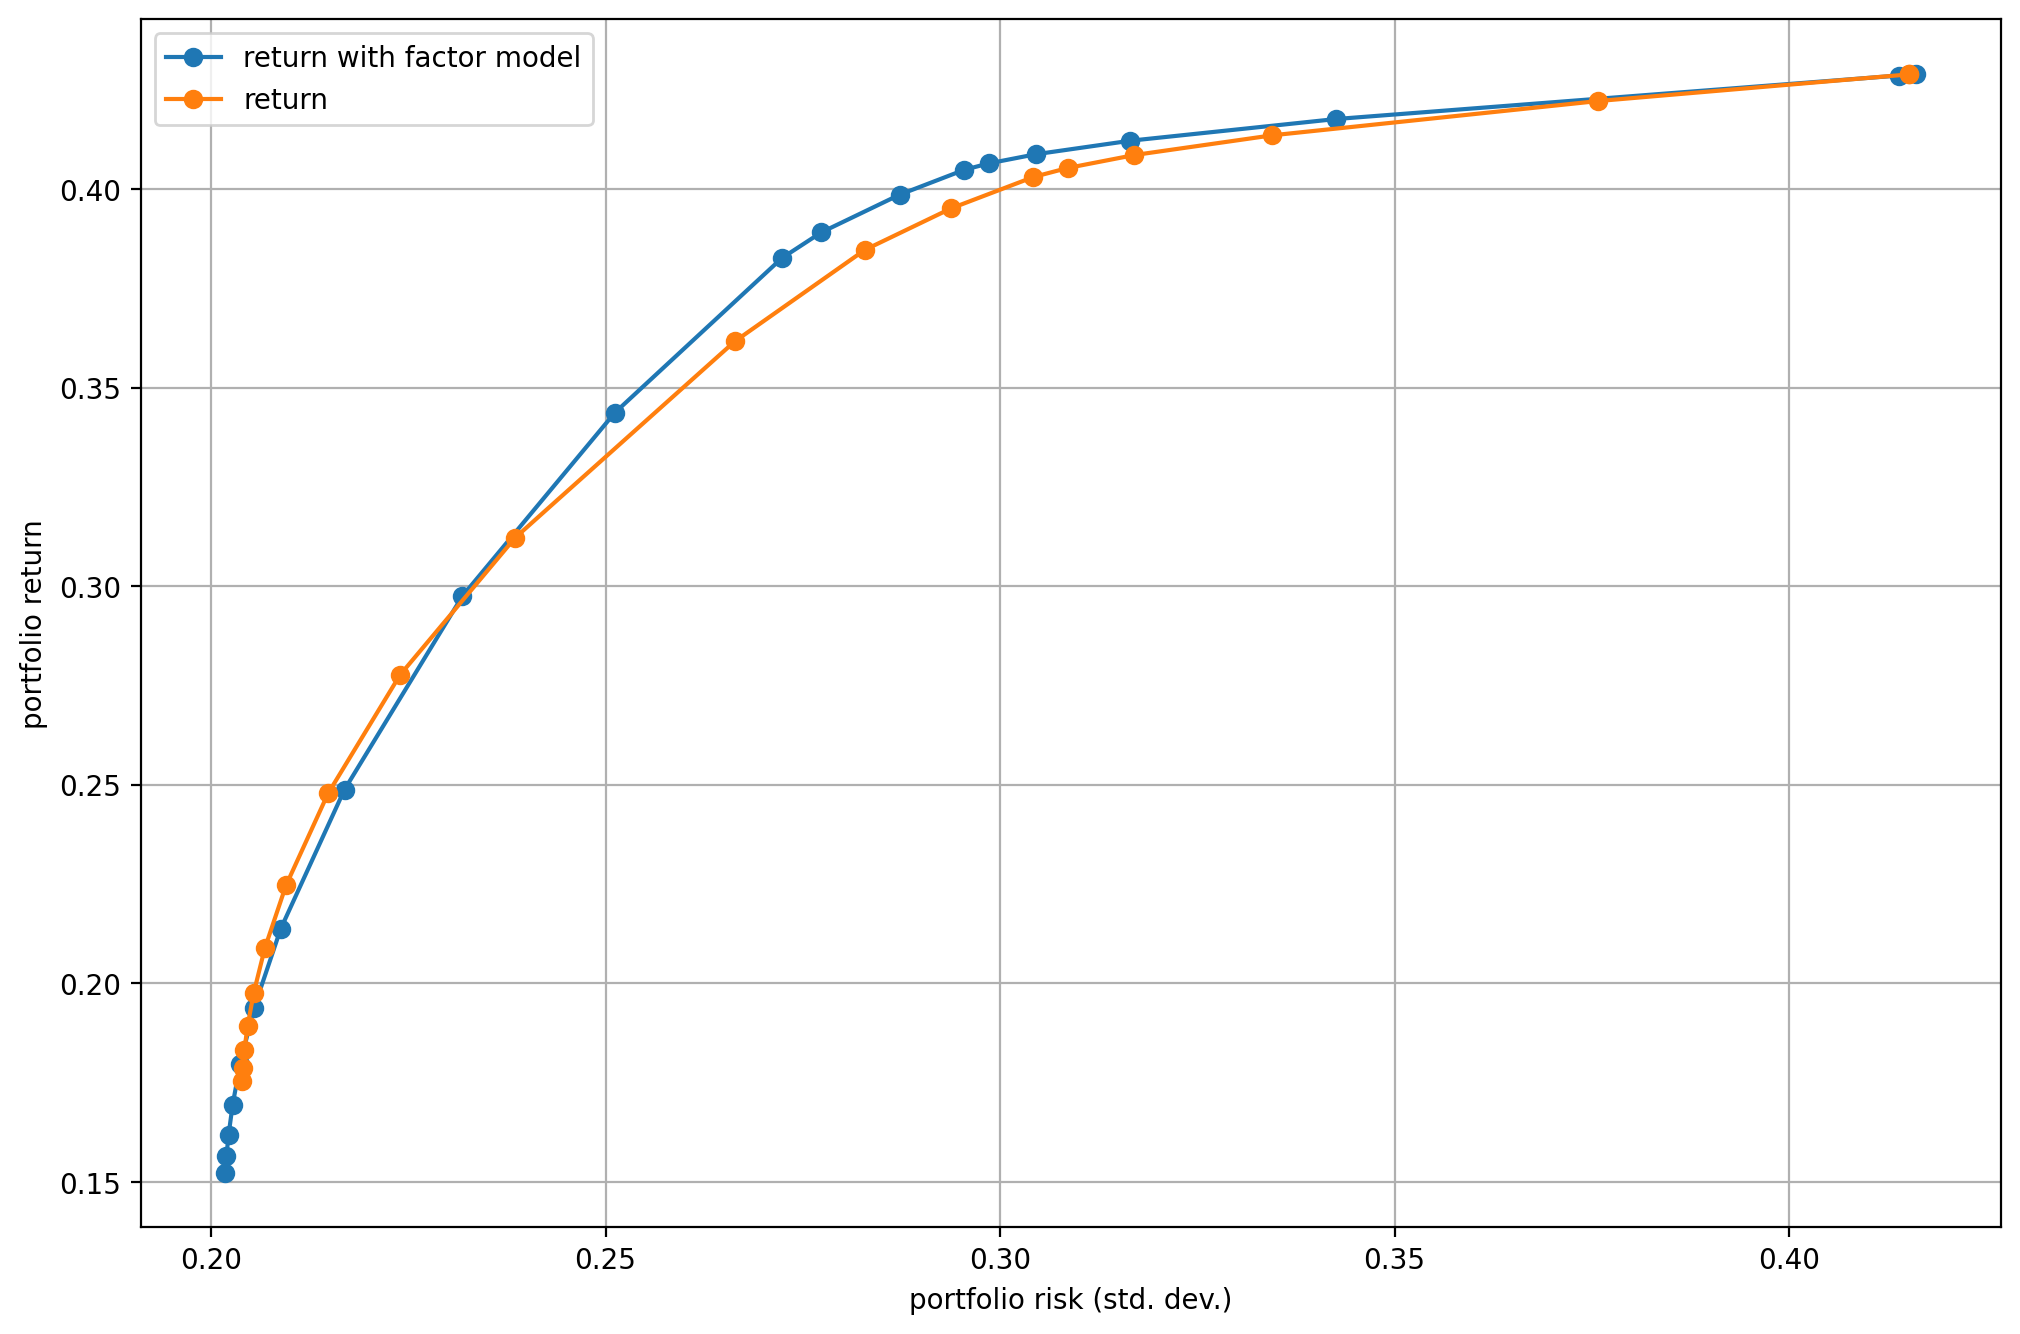

In [63]:
# Efficient frontier
ax = df_result_factor.plot(x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
df_result_orig.plot(ax=ax, x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)   
ax.legend(["return with factor model", "return"]);

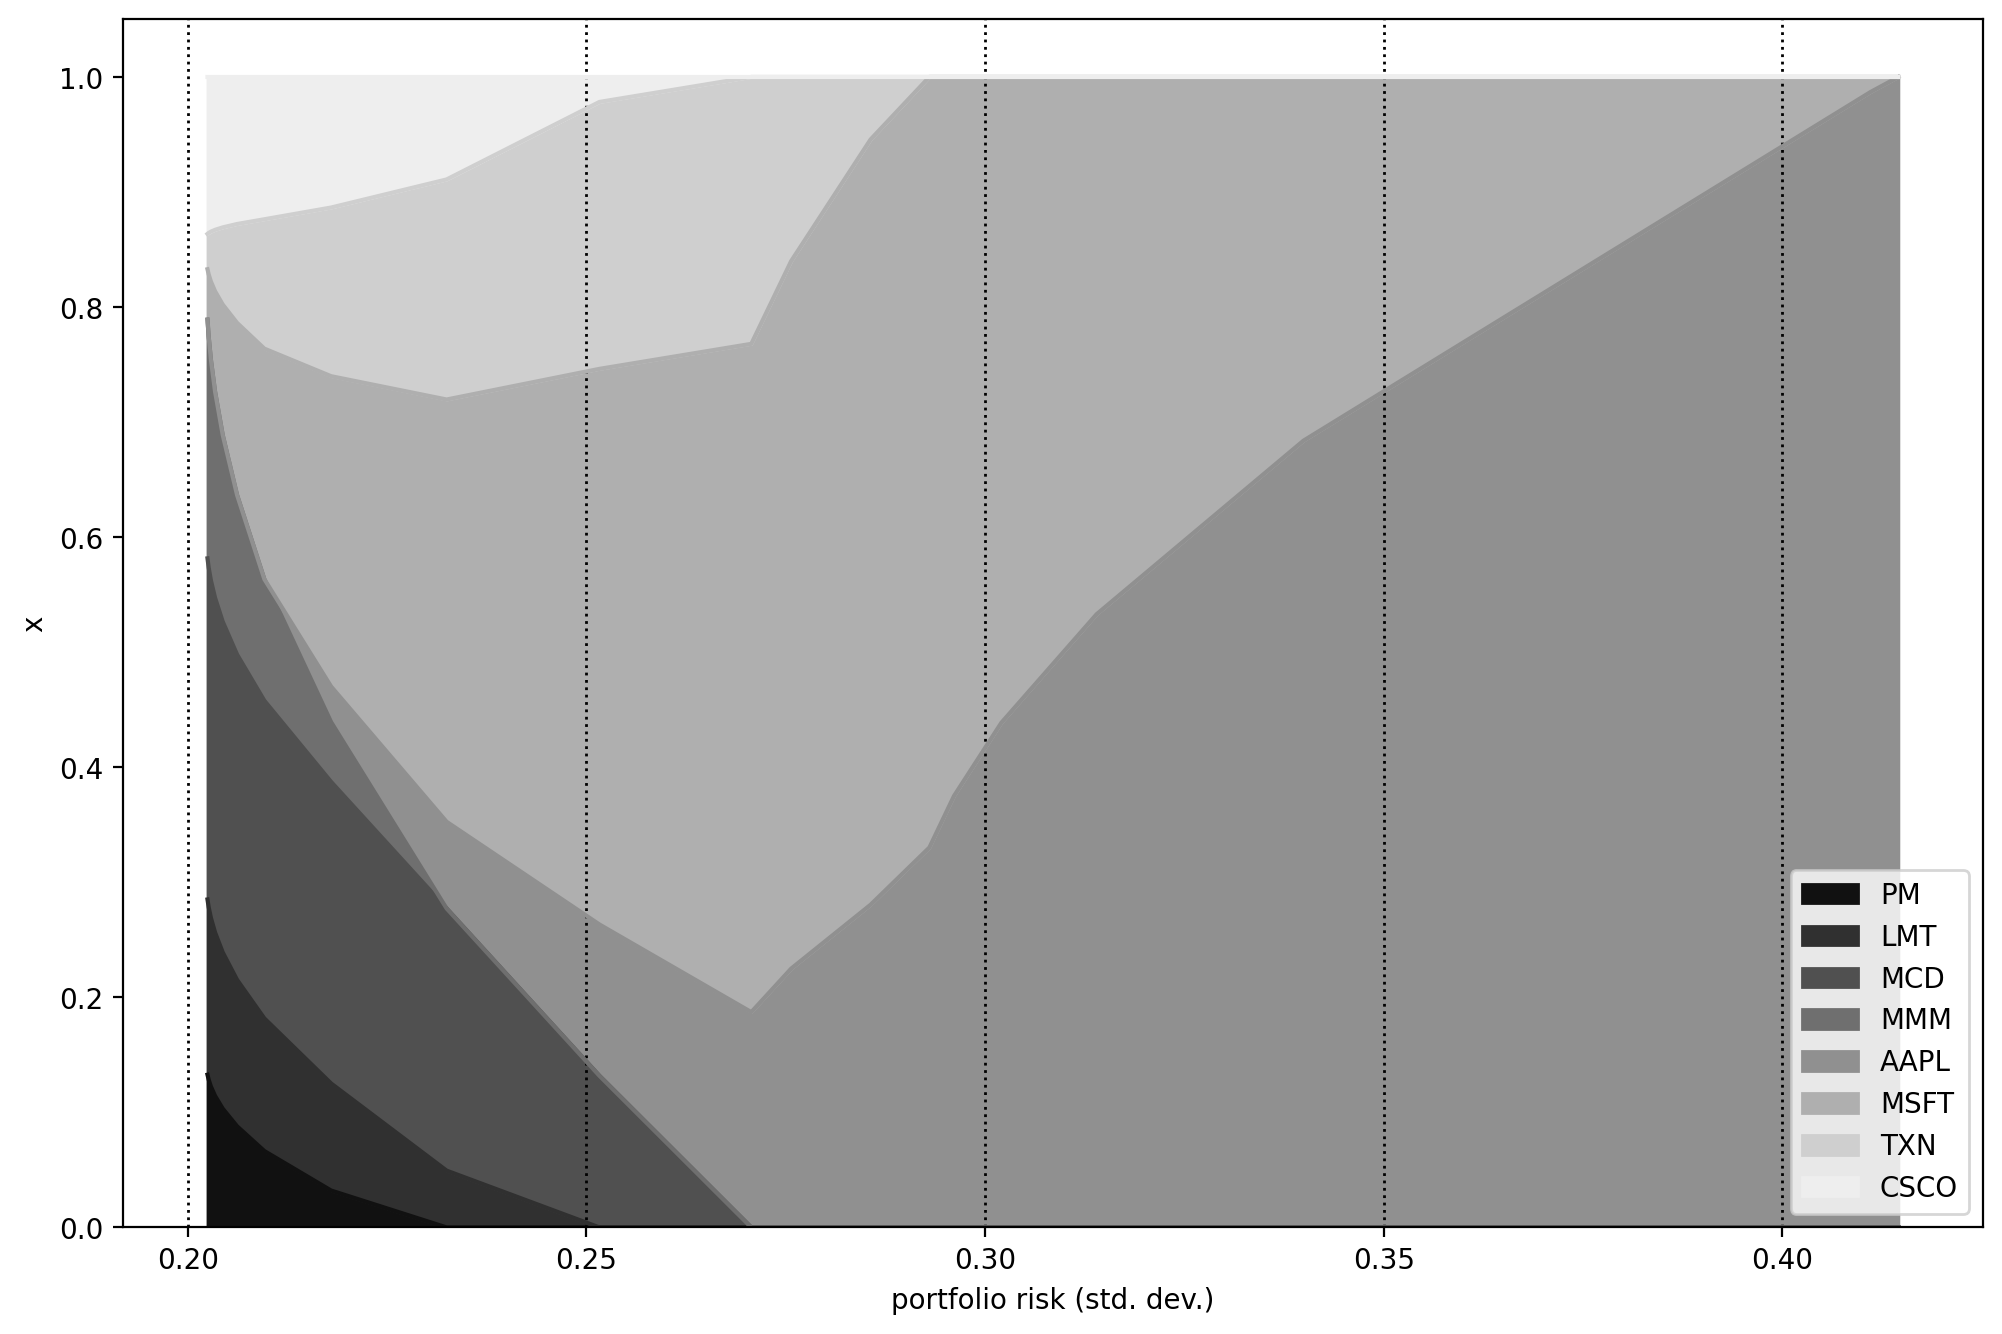

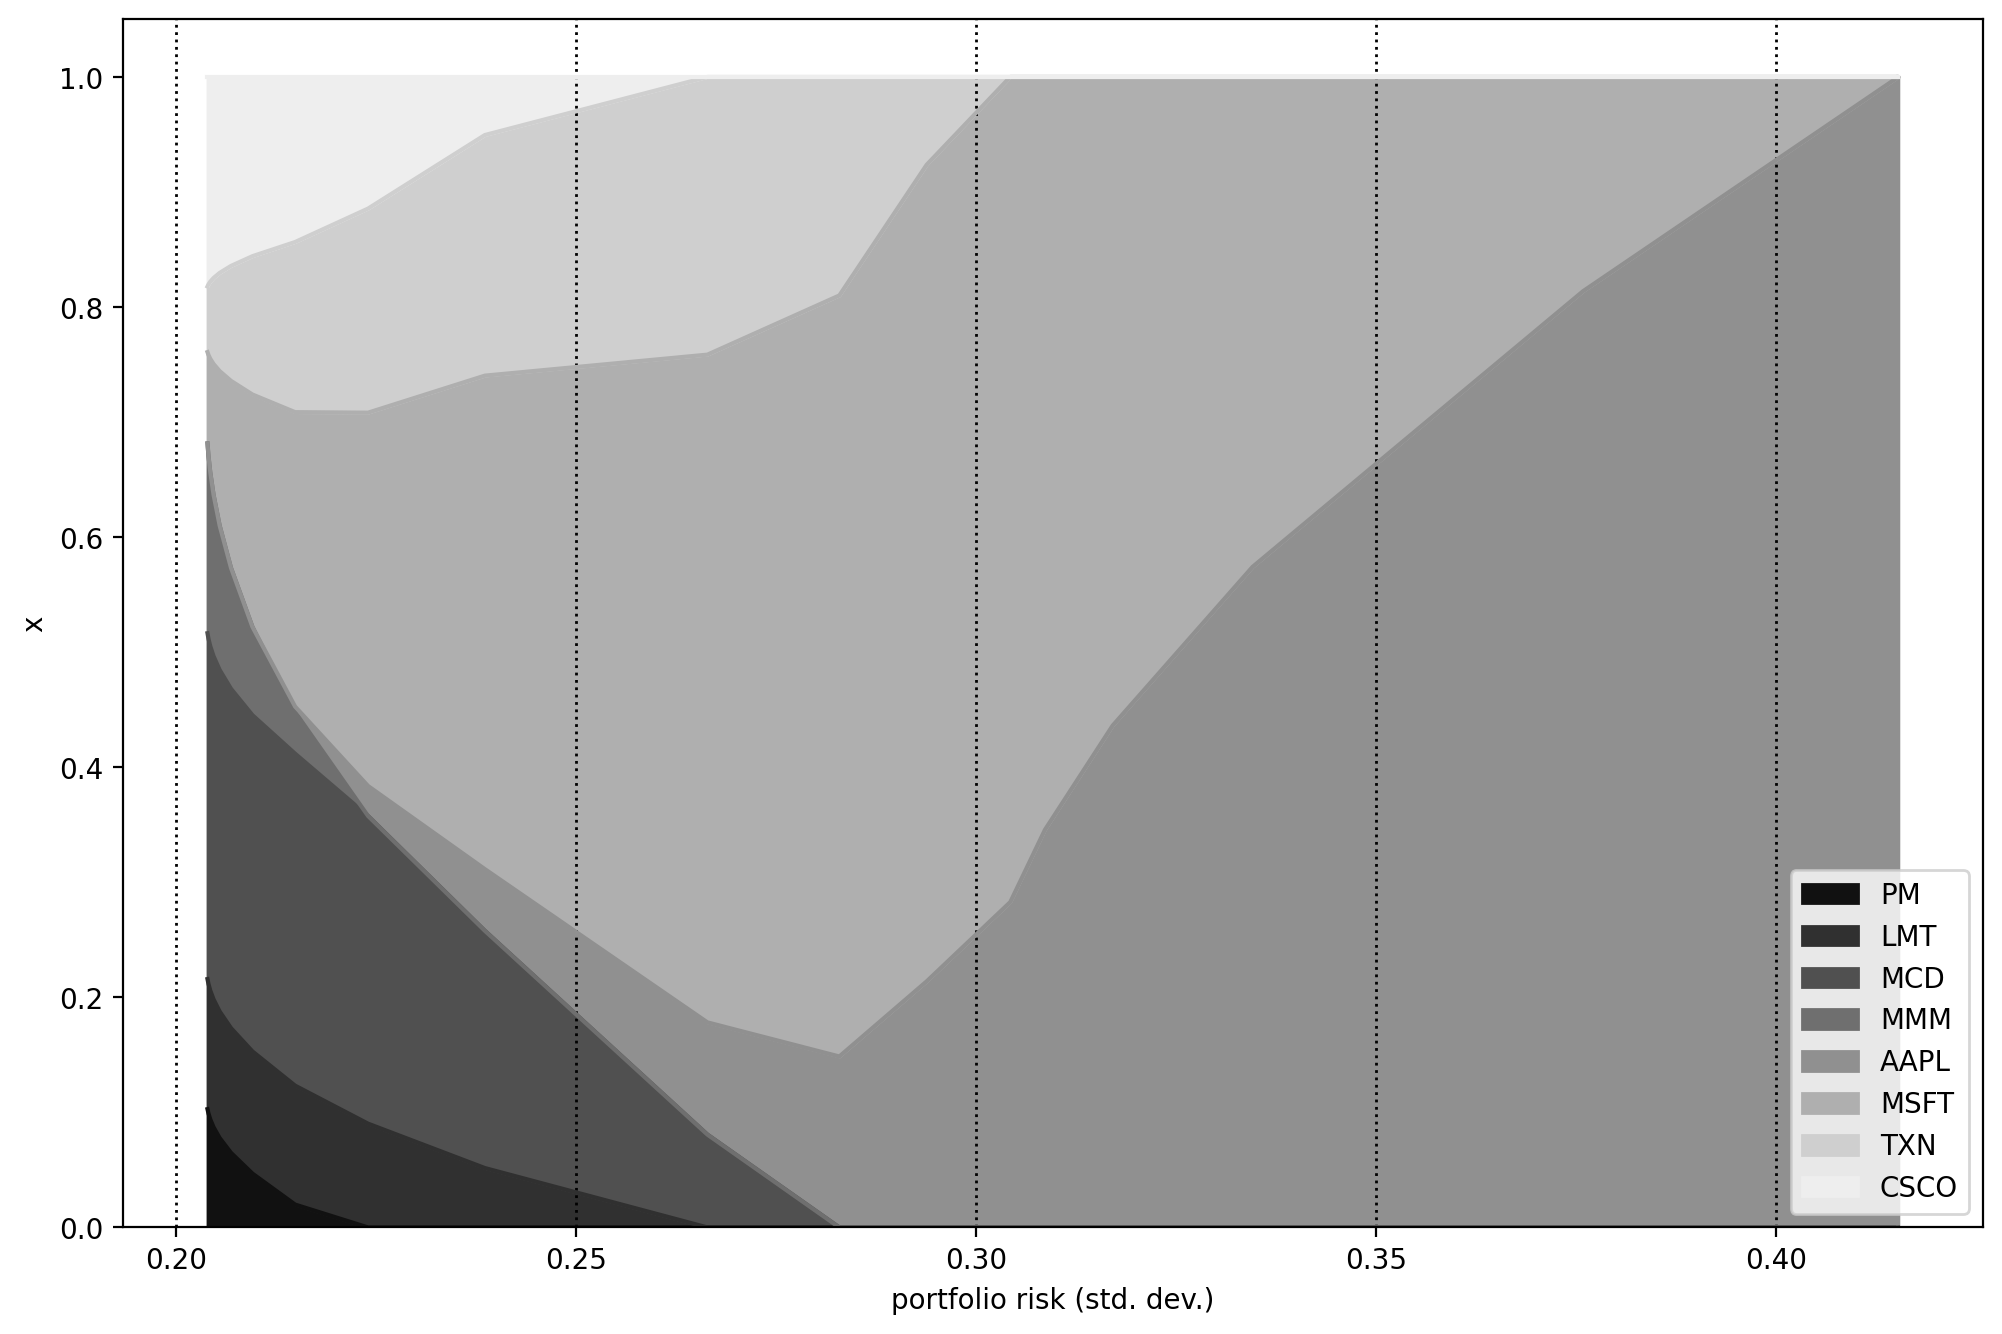

In [60]:
# Plot portfolio composition
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax1 = df_result_factor.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x")
ax1.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)
ax2 = df_result_orig.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x") 
ax2.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)